# **Importing Libraries and Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from random import randint
from IPython.display import display, Javascript
from google.colab import drive, files
import os


# **Mounting Drive to get the Dataset**

In [ ]:


# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Define the paths to the training and testing directories
train_dir = '/content/drive/My Drive/project2/rps'
test_dir = '/content/drive/My Drive/project2/rps-test-set'

# List the classes (subdirectories) in the training directory
classes = os.listdir(train_dir)

print("Classes (subdirectories) in the training directory:")
print(classes)


Mounted at /content/drive
Classes (subdirectories) in the training directory:
['paper', 'rock', 'scissors']


There are 2520 samples in training set
There are 372 samples in test set


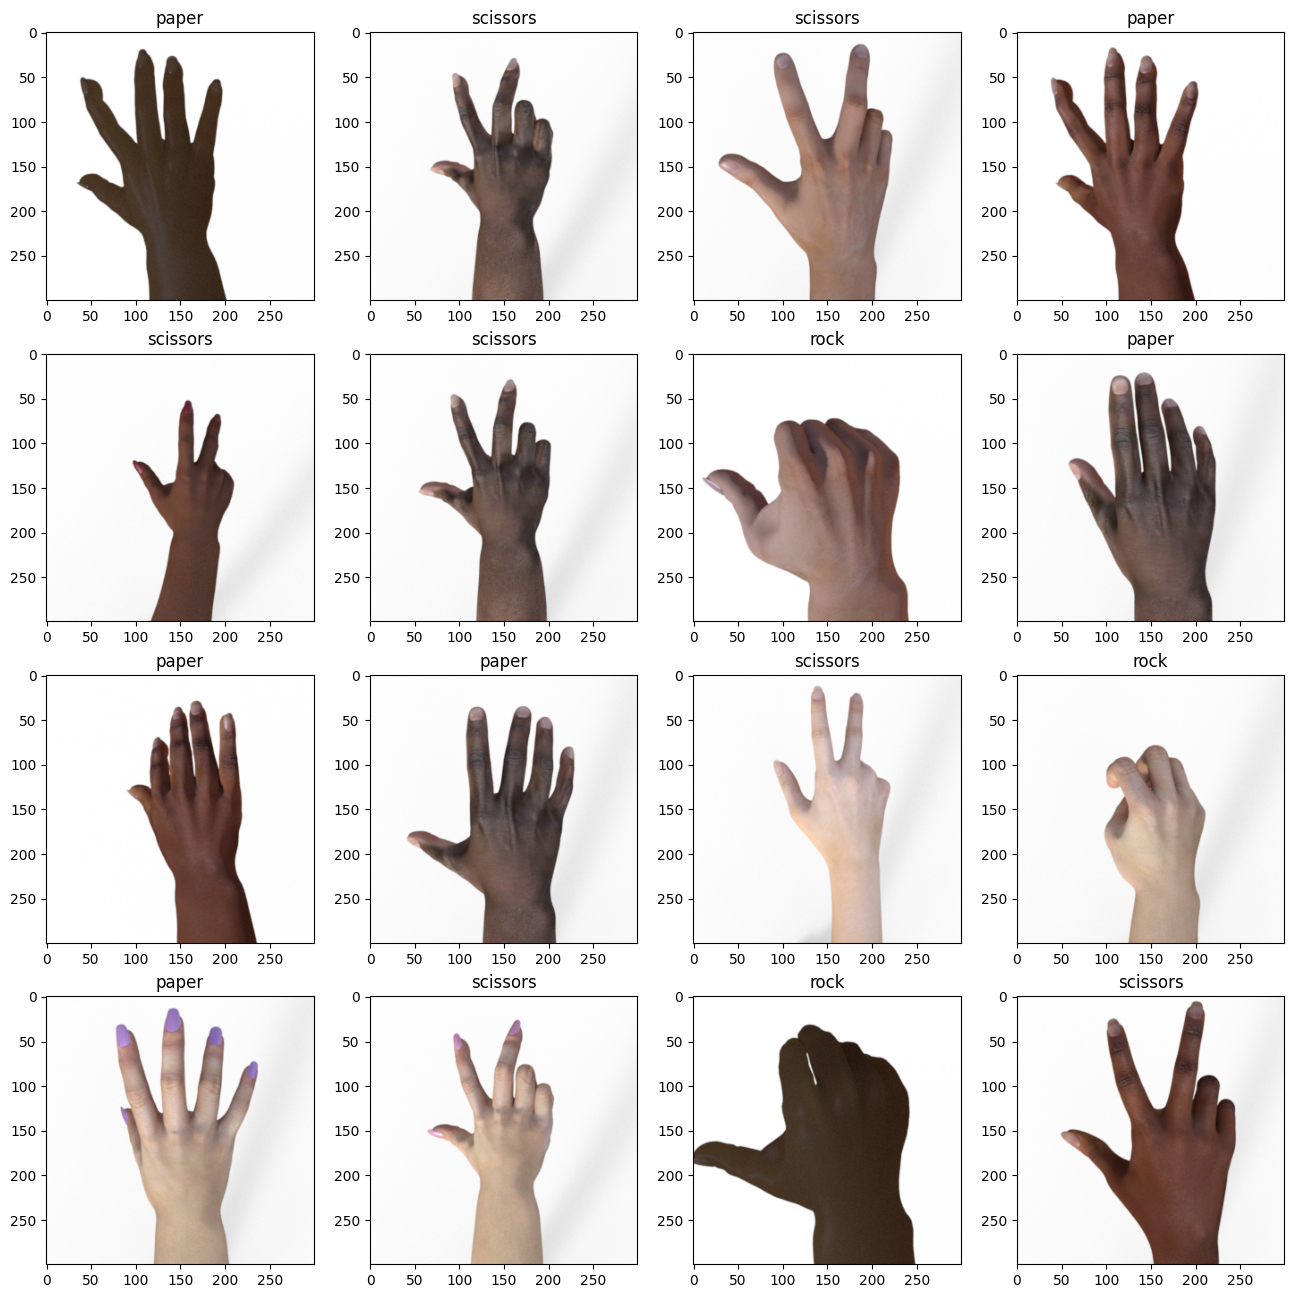

In [ ]:


X_train_val = []
y_train_val = []
for i, cls in enumerate(os.listdir(train_dir)):
    for img in os.listdir(os.path.join(train_dir, cls)):
        image = cv2.imread(os.path.join(train_dir, cls, img))
        X_train_val.append(image)
        y_train_val.append(i)
X_test = []
y_test = []
for i, cls in enumerate(os.listdir(test_dir)):
    for img in os.listdir(os.path.join(test_dir, cls)):
        image = cv2.imread(os.path.join(test_dir, cls, img))
        X_test.append(image)
        y_test.append(i)
X_test = np.array(X_test)
X_train_val = np.array(X_train_val)
y_test = np.array(y_test)
y_train_val = np.array(y_train_val)

print(f'There are {X_train_val.shape[0]} samples in training set')
print(f'There are {X_test.shape[0]} samples in test set')

fig, axes = plt.subplots(4,4,figsize=(16,16))
for i in range(16):
    idx = randint(0, X_train_val.shape[0]-1)
    img = X_train_val[idx]
    label = y_train_val[idx]
    axes[i//4][i%4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i//4][i%4].title.set_text(classes[label])

plt.show()


In [ ]:
X_train_val.shape

(2520, 300, 300, 3)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  image_size=(180,180),
  batch_size=32,
  seed=42)

Found 2520 files belonging to 3 classes.
Using 2016 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  image_size=(180,180),
  batch_size=32,
  seed=42)


Found 2520 files belonging to 3 classes.
Using 504 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['paper', 'rock', 'scissors']

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
  tf.keras.layers.RandomRotation(0.1, seed=42),
])

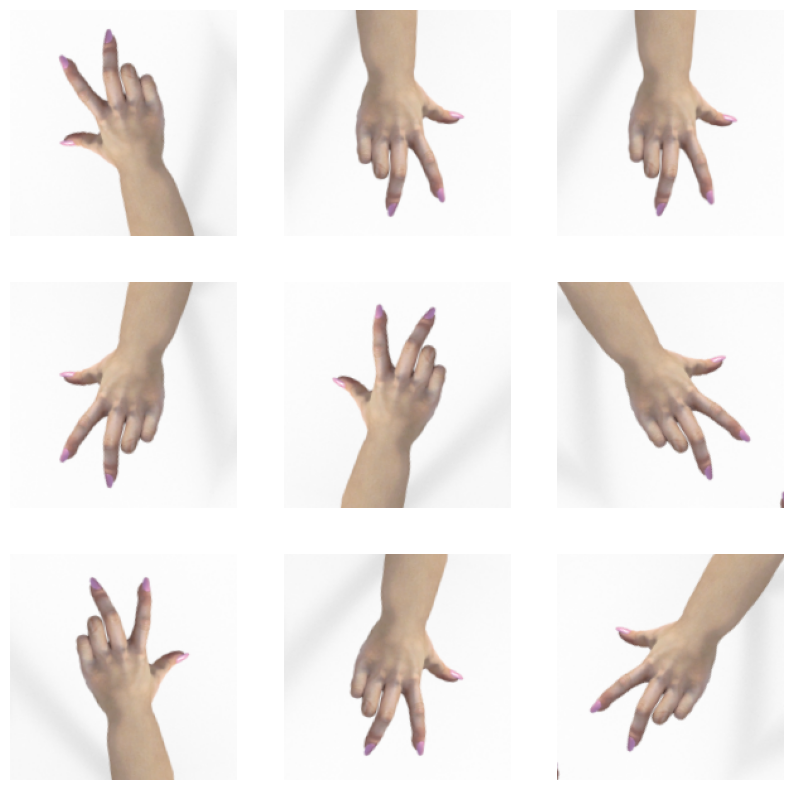

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
NUM_CLASSES = len(class_names)

# **Defining a Custom CNN Model**

In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    data_augmentation,
    # The first CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # The second CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # The third CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # The fourth CNN layer
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

# **Compiling the Model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# **Model Training**

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
)

Epoch 1/20
63/63 [==============================] - 582s 9s/step - loss: 1.1841 - accuracy: 0.3671 - val_loss: 1.0801 - val_accuracy: 0.4444
Epoch 2/20
63/63 [==============================] - 577s 9s/step - loss: 0.9090 - accuracy: 0.5595 - val_loss: 0.8660 - val_accuracy: 0.5238
Epoch 3/20
63/63 [==============================] - 567s 9s/step - loss: 0.5417 - accuracy: 0.7669 - val_loss: 0.3347 - val_accuracy: 0.8631
Epoch 4/20
63/63 [==============================] - 571s 9s/step - loss: 0.2456 - accuracy: 0.9122 - val_loss: 0.1274 - val_accuracy: 0.9583
Epoch 5/20
63/63 [==============================] - 572s 9s/step - loss: 0.1242 - accuracy: 0.9588 - val_loss: 0.0582 - val_accuracy: 0.9802
Epoch 6/20
63/63 [==============================] - 572s 9s/step - loss: 0.0973 - accuracy: 0.9678 - val_loss: 0.1284 - val_accuracy: 0.9325
Epoch 7/20
63/63 [==============================] - 572s 9s/step - loss: 0.0413 - accuracy: 0.9846 - val_loss: 0.0210 - val_accuracy: 0.9940
Epoch 8/20
63

# **Training Results**

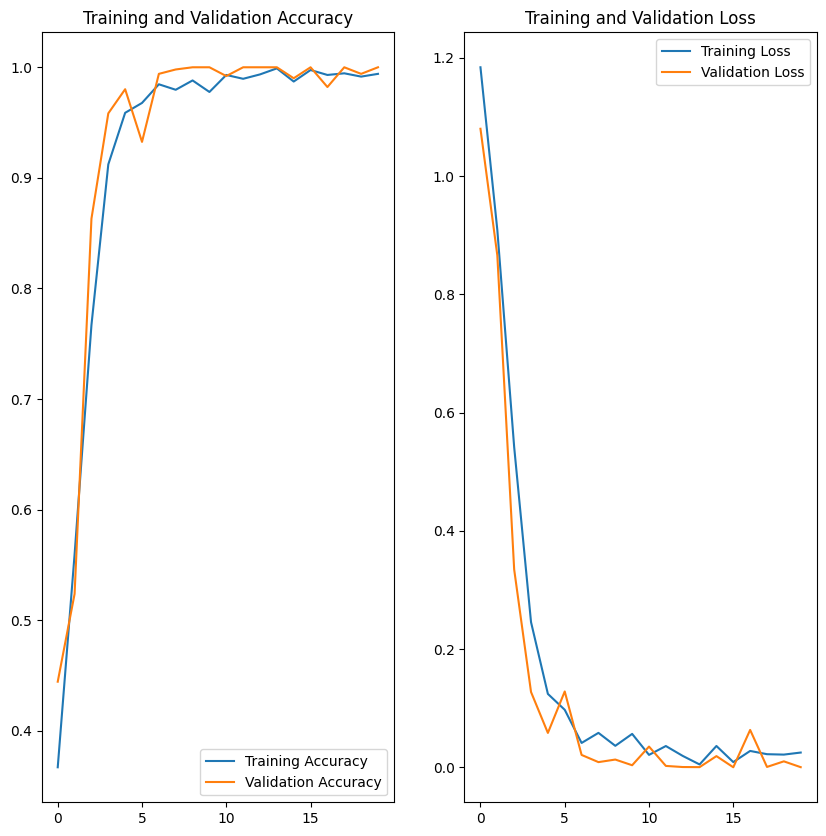

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Model Evaluation and Predictions**

In [ ]:
# Create the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(180, 180),
  batch_size=32
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Found 372 files belonging to 3 classes.
12/12 [==============================] - 31s 2s/step - loss: 0.2778 - accuracy: 0.9355
Test Loss: 0.2778271734714508
Test Accuracy: 0.9354838728904724


In [ ]:
# Randomly select an image from the test dataset
random_index = np.random.randint(0, len(test_ds))
for images, labels in test_ds.take(random_index):
    # Get the predicted probabilities from the model
    predictions = model.predict(images)
    # Get the predicted label and confidence score
    score = tf.nn.softmax(predictions[0])
    predicted_label = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    # Get the true label
    true_label = class_names[labels[0]]

    # Display the true label and predicted label with confidence
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print("Confidence:", confidence, "%")

    # Display image properties
    print("Image Shape:", images[0].shape)
    print("Image Minimum Value:", np.min(images[0]))
    print("Image Maximum Value:", np.max(images[0]))
    print("Image Mean Value:", np.mean(images[0]))
    print("Image Data Type:", images[0].dtype)

1/1 [==============================] - 3s 3s/step
True Label: paper
Predicted Label: paper
Confidence: 100.0 %
Image Shape: (180, 180, 3)
Image Minimum Value: 22.999996
Image Maximum Value: 255.0
Image Mean Value: 208.54387
Image Data Type: <dtype: 'float32'>
1/1 [==============================] - 3s 3s/step
True Label: scissors
Predicted Label: scissors
Confidence: 100.0 %
Image Shape: (180, 180, 3)
Image Minimum Value: 38.0
Image Maximum Value: 255.0
Image Mean Value: 220.02048
Image Data Type: <dtype: 'float32'>


In [ ]:

# Upload the image
uploaded = files.upload()

# Process the uploaded image
filename = next(iter(uploaded.keys()))  # Get the filename of the uploaded image
# Load the image using matplotlib
img = mpimg.imread(filename)
# Preprocess the image
img = tf.image.resize(img, (180, 180))  # Resize the image
img = tf.expand_dims(img, axis=0)  # Add batch dimension
#img = img / 255.0  # Normalize the image

# Predict using the model
predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])
predicted_label = class_names[np.argmax(score)]
confidence = 100 * np.max(score)


# Display image properties
print("Image Shape:", img[0].shape)
print("Image Minimum Value:", np.min(img[0]))
print("Image Maximum Value:", np.max(img[0]))
print("Image Mean Value:", np.mean(img[0]))
print("Image Data Type:", img[0].dtype)

# Display prediction result
print("Predicted Label:", predicted_label)
print("Confidence:", confidence, "%")


Saving i1.jpg to i1.jpg
1/1 [==============================] - 0s 187ms/step
Image Shape: (180, 180, 3)
Image Minimum Value: 58.694427
Image Maximum Value: 255.0
Image Mean Value: 225.4683
Image Data Type: <dtype: 'float32'>
Predicted Label: paper
Confidence: 99.28339719772339 %


# **Saving the Model**

In [ ]:

# serialize model to JSON
model_json = model.to_json()
with open("saved_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("saved_model.h5")
print("Saved model to disk")

Saved model to disk


# **Re-Loading the Model**

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# **Evaluating the Re-Loaded Model**

In [ ]:
# Evaluate the model on the test dataset
new_test_loss, new_test_accuracy = loaded_model.evaluate(test_ds)

# Print the test loss and accuracy
print('New Test Loss:', new_test_loss)
print('New Test Accuracy:', new_test_accuracy)

12/12 [==============================] - 33s 3s/step - loss: 0.2778 - accuracy: 0.9355
New Test Loss: 0.2778272032737732
New Test Accuracy: 0.9354838728904724
